In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.set_printoptions(threshold=100000000000000)
import pandas as pd 
pd.set_option('max_columns',100000000000)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
sample_sub = pd.read_csv('data/SampleSubmission.csv')
var_desc = pd.read_csv('data/VariableDefinitions.csv')

In [3]:
var_desc

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [4]:
len(train), len(test)

(12079, 5177)

In [5]:
test.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     156
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              1638
Subject_Car_Colour        3005
Subject_Car_Make          1061
LGA_Name                  2782
State                     2788
ProductName                  0
dtype: int64

In [6]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [7]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,009D84L,2010-04-24,2011-03-27,NO GENDER,25,2010-04-24,1,NaN,As Attached,Iveco,Victoria Island,Lagos,CVTP
1,01DO2EQ,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Muuve
2,01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
3,024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
4,02BYET3,2010-09-16,2010-12-31,NaN,120,2010-09-16,4,NaN,NaN,TOYOTA,Victoria Island,Lagos,Muuve


In [8]:
train['Policy Start Date'] = train['Policy Start Date'].astype('datetime64')
train['Policy End Date'] = train['Policy End Date'].astype('datetime64')
train['First Transaction Date'] = train['First Transaction Date'].astype('datetime64')
test['Policy Start Date'] = test['Policy Start Date'].astype('datetime64')
test['Policy End Date'] = test['Policy End Date'].astype('datetime64')
test['First Transaction Date'] = test['First Transaction Date'].astype('datetime64')

In [9]:
train['Policy_duration'] = train['Policy End Date'] - train['Policy Start Date']
test['Policy_duration'] = test['Policy End Date'] - test['Policy Start Date']
train['since_fp'] = train['Policy End Date'] - train['First Transaction Date']
test['since_fp'] = test['Policy End Date'] - test['First Transaction Date']

In [10]:
train['Policy_duration'] = train['Policy_duration'].astype(str).apply(lambda x:x.split(' ')[0])
test['Policy_duration'] = test['Policy_duration'].astype(str).apply(lambda x:x.split(' ')[0])

In [11]:
train['Policy_duration']

0        364
1        364
2        364
3        364
4        124
        ... 
12074    364
12075    364
12076    363
12077    364
12078    364
Name: Policy_duration, Length: 12079, dtype: object

In [12]:
train['since_fp'].dtype

dtype('<m8[ns]')

In [13]:
train['since_fp'] = train['since_fp'].astype(str).apply(lambda x:x.split(' ')[0])
test['since_fp'] = test['since_fp'].astype(str).apply(lambda x:x.split(' ')[0])

In [14]:
train['since_fp']

0        364
1        364
2        364
3        364
4        124
        ... 
12074    364
12075    364
12076    363
12077    364
12078    364
Name: since_fp, Length: 12079, dtype: object

In [15]:
def extract_date_info(df,cols):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.quarter
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
    df.drop(columns=cols,axis=1,inplace=True)

In [16]:
train.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target', 'Policy_duration', 'since_fp'],
      dtype='object')

In [17]:
extract_date_info(train,['Policy Start Date','Policy End Date','First Transaction Date'])

In [18]:
train.head()

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy_duration,since_fp,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter
0,0040R73,Male,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0,364,364,2,14,5,2,2,13,5,2,2,14,5,2
1,0046BNK,Female,79,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1,364,364,4,29,11,4,4,28,11,4,4,29,11,4
2,005QMC3,Male,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0,364,364,1,21,3,1,1,20,3,1,1,21,3,1
3,0079OHW,Male,2,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,364,364,3,21,8,3,3,20,8,3,3,21,8,3
4,00BRP63,Entity,20,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1,124,124,3,29,8,3,4,31,12,4,3,29,8,3


In [19]:
extract_date_info(test,['Policy Start Date','Policy End Date','First Transaction Date'])

In [20]:
print(train.isna().sum())
print(test.isna().sum())

ID                                   0
Gender                             359
Age                                  0
No_Pol                               0
Car_Category                      3738
Subject_Car_Colour                6962
Subject_Car_Make                  2476
LGA_Name                          6476
State                             6488
ProductName                          0
target                               0
Policy_duration                      0
since_fp                             0
Policy Start Date_year               0
Policy Start Date_day                0
Policy Start Date_month              0
Policy Start Date_quarter            0
Policy End Date_year                 0
Policy End Date_day                  0
Policy End Date_month                0
Policy End Date_quarter              0
First Transaction Date_year          0
First Transaction Date_day           0
First Transaction Date_month         0
First Transaction Date_quarter       0
dtype: int64
ID          

In [21]:
train['Gender'].unique()

array(['Male', 'Female', 'Entity', 'Joint Gender', nan, 'NO GENDER',
       'NOT STATED', 'SEX'], dtype=object)

In [22]:
train['Gender'].value_counts()

Male            7617
Female          3327
Entity           277
Joint Gender     223
NOT STATED       175
NO GENDER         66
SEX               35
Name: Gender, dtype: int64

In [23]:
train['Gender'] = train['Gender'].replace({'Joint Gender':'Entity','NOT STATED':'Not known','NO GENDER':'Not known','SEX':'Not known',np.nan:'Not known'})

In [24]:
test['Gender'] = test['Gender'].replace({'Joint Gender':'Entity','NOT STATED':'Not known','NO GENDER':'Not known','SEX':'Not known',np.nan:'Not known'})

In [25]:
train['Gender'].value_counts()

Male         7617
Female       3327
Not known     635
Entity        500
Name: Gender, dtype: int64

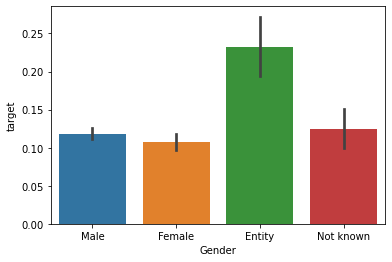

In [26]:
sns.barplot('Gender','target',data=train);

In [27]:
train['Gender'] = train['Gender'].replace({'Entity':0,'Male':1,'Female':2,'Not known':3})

In [28]:
test['Gender'] = test['Gender'].replace({'Entity':0,'Male':1,'Female':2,'Not known':3})

In [29]:
train.head()

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy_duration,since_fp,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter
0,0040R73,1,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0,364,364,2,14,5,2,2,13,5,2,2,14,5,2
1,0046BNK,2,79,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1,364,364,4,29,11,4,4,28,11,4,4,29,11,4
2,005QMC3,1,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0,364,364,1,21,3,1,1,20,3,1,1,21,3,1
3,0079OHW,1,2,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,364,364,3,21,8,3,3,20,8,3,3,21,8,3
4,00BRP63,0,20,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1,124,124,3,29,8,3,4,31,12,4,3,29,8,3


In [30]:
train['Car_Category'].unique()

array(['Saloon', 'JEEP', nan, 'Motorcycle', 'Truck', 'Bus', 'Mini Bus',
       'Pick Up', 'Mini Van', 'Van', 'Pick Up > 3 Tons', 'CAMRY CAR HIRE',
       'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel',
       'Tipper Truck'], dtype=object)

In [31]:
train['Car_Category'].fillna('Not Known',inplace=True)
test['Car_Category'].fillna('Not Known',inplace=True)

In [32]:
train['Subject_Car_Colour'].unique()

array(['Black', 'Grey', 'Red', nan, 'As Attached', 'Blue', 'Silver',
       'Green', 'Ash', 'White', 'Gray & Gray', 'Wine', 'Brown',
       'Red & Blue', 'Gold', 'Gray & Silver', 'Orange', 'Red & Black',
       'Dark Grey', 'White & Red', 'Light Green', 'Dark Gray', 'B.Silver',
       'Purple', 'Blue & Red', 'Red & Yellow', 'Yellow', 'Red & White',
       'D. Red', 'Dark Red', 'Black & White', 'White & Blue', 'Cream',
       'Dark Green', 'D. Gold', 'Champagne', 'Light Blue',
       'Blue&White&Red', 'White & Yellow', 'Dark Blue', 'Black & Orange',
       'Burgundy', 'Yellow & White', 'Beige Mitalic', 'Light Gray',
       'Blue Sky'], dtype=object)

In [33]:
test['Subject_Car_Colour'].unique()

array(['As Attached', nan, 'Black', 'Red', 'Green', 'Silver', 'Grey',
       'Gold', 'Ash', 'White', 'Wine', 'Blue', 'Dark Red', 'Brown',
       'White & Blue', 'Red & Black', 'Red Maroon', 'Orange', 'Dark Gray',
       'Red & Yellow', 'Blue&White&Red', 'Gray & Gray', 'D. Gold',
       'Dark Grey', 'Red & White', 'Yellow & White', 'Cream',
       'Blue & Red', 'Light Green', 'Dark Blue', 'Blue Sky',
       'Black & Orange', 'Purple', 'B.Silver', 'Burgundy',
       'Gray & Silver', 'Yellow', 'Beige Mitalic'], dtype=object)

In [34]:
color_map = {
    np.nan:'Not known',
    'As Attached': 'Not known',
    'Gray & Gray':'Gray',
    'Dark Grey':'Gray',
    'Light Green': 'Green',
    'Dark Gray': 'Gray',
    'B.Silver': 'Silver',
    'D. Red': 'Red',
    'Dark Red': 'Red',
    'Dark Green': "Green",
    'D. Gold': "Gold",
    'Light Blue':'Blue',
    'Dark Blue': 'Blue',
    'Beige Mitalic':'Beige',
    'Light Gray':'Gray',
    'Blue Sky':'Blue',
    'Red Maroon':'Red',
    'Grey':'Gray'
}

train['Subject_Car_Colour'] = train['Subject_Car_Colour'].replace(color_map)
test['Subject_Car_Colour'] = test['Subject_Car_Colour'].replace(color_map)

In [35]:
train['Subject_Car_Make'].unique()

array(['TOYOTA', nan, 'REXTON', 'Lexus', 'Hyundai', 'Iveco', 'DAF',
       'Honda', 'Mercedes', 'Jincheng', 'ACURA', 'Ford', 'Volkswagen',
       'Nissan', '.', 'Pontiac', 'Range Rover', 'Kia', 'Mitsubishi',
       'Scania', 'BMW', 'Infiniti', 'Renault', 'Volvo', 'Hummer', 'Mack',
       'Grand Cherokee', 'Porsche', 'Peugeot', 'Land Rover', 'Chevrolet',
       'Mazda', 'Man', 'Jeep', 'Audi', 'Suzuki', 'MINI COOPER', 'KA',
       'As Attached', 'Innson', 'Isuzu', 'Skoda', 'Jaguar', 'Chrysler',
       'Dodge', 'GMC', 'Land Rover.', 'Subaru', 'GAC', 'Fiat', 'Opel',
       'Astra', 'Motorcycle', 'ZOYTE', 'Seat', 'FOTON', 'Howo', 'Lincoln',
       'Rols Royce', 'CHANGAN', 'LIBERTY', 'ABG', 'Yamaha', 'Black',
       'Tata', 'Ashok Leyland', 'Geely', 'Caddillac', 'Wrangler Jeep',
       'Raston', 'MG', 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj'],
      dtype=object)

In [36]:
train['Subject_Car_Make'].unique()

array(['TOYOTA', nan, 'REXTON', 'Lexus', 'Hyundai', 'Iveco', 'DAF',
       'Honda', 'Mercedes', 'Jincheng', 'ACURA', 'Ford', 'Volkswagen',
       'Nissan', '.', 'Pontiac', 'Range Rover', 'Kia', 'Mitsubishi',
       'Scania', 'BMW', 'Infiniti', 'Renault', 'Volvo', 'Hummer', 'Mack',
       'Grand Cherokee', 'Porsche', 'Peugeot', 'Land Rover', 'Chevrolet',
       'Mazda', 'Man', 'Jeep', 'Audi', 'Suzuki', 'MINI COOPER', 'KA',
       'As Attached', 'Innson', 'Isuzu', 'Skoda', 'Jaguar', 'Chrysler',
       'Dodge', 'GMC', 'Land Rover.', 'Subaru', 'GAC', 'Fiat', 'Opel',
       'Astra', 'Motorcycle', 'ZOYTE', 'Seat', 'FOTON', 'Howo', 'Lincoln',
       'Rols Royce', 'CHANGAN', 'LIBERTY', 'ABG', 'Yamaha', 'Black',
       'Tata', 'Ashok Leyland', 'Geely', 'Caddillac', 'Wrangler Jeep',
       'Raston', 'MG', 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj'],
      dtype=object)

In [37]:
make_mapper = {
    np.nan:'Not known',
    'As Attached':'Not known',
    '.':'Not known'
}
train['Subject_Car_Make'] = train['Subject_Car_Make'].replace(make_mapper)
test['Subject_Car_Make'] = test['Subject_Car_Make'].replace(make_mapper)

In [38]:
train.head()

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy_duration,since_fp,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter
0,0040R73,1,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0,364,364,2,14,5,2,2,13,5,2,2,14,5,2
1,0046BNK,2,79,1,JEEP,Gray,TOYOTA,NaN,NaN,Car Classic,1,364,364,4,29,11,4,4,28,11,4,4,29,11,4
2,005QMC3,1,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0,364,364,1,21,3,1,1,20,3,1,1,21,3,1
3,0079OHW,1,2,1,Not Known,Not known,Not known,NaN,NaN,CarSafe,0,364,364,3,21,8,3,3,20,8,3,3,21,8,3
4,00BRP63,0,20,3,Not Known,Not known,Not known,Lagos,Lagos,Muuve,1,124,124,3,29,8,3,4,31,12,4,3,29,8,3


In [39]:
train['LGA_Name'].fillna('Not known',inplace=True)
test['LGA_Name'].fillna('Not known',inplace=True)
train['State'].fillna('Not known',inplace=True)
test['State'].fillna('Not known',inplace=True)

In [40]:
cat_features = ['No_Pol','Car_Category','Subject_Car_Colour','Subject_Car_Make','LGA_Name','State',"ProductName"]

In [41]:
all_data = pd.concat([train,test])

In [42]:
for i in cat_features:
    all_data[i] = all_data[i].astype('category')

In [43]:
all_data.dtypes

ID                                  object
Gender                               int64
Age                                  int64
No_Pol                            category
Car_Category                      category
Subject_Car_Colour                category
Subject_Car_Make                  category
LGA_Name                          category
State                             category
ProductName                       category
target                             float64
Policy_duration                     object
since_fp                            object
Policy Start Date_year               int64
Policy Start Date_day                int64
Policy Start Date_month              int64
Policy Start Date_quarter            int64
Policy End Date_year                 int64
Policy End Date_day                  int64
Policy End Date_month                int64
Policy End Date_quarter              int64
First Transaction Date_year          int64
First Transaction Date_day           int64
First Trans

In [44]:
for label, value in all_data.items():
    if pd.api.types.is_categorical_dtype(value):
        all_data[label] = pd.Categorical(value).codes

In [45]:
all_data.head()

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy_duration,since_fp,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter
0,0040R73,1,30,0,9,2,67,183,82,1,0.0,364,364,2,14,5,2,2,13,5,2,2,14,5,2
1,0046BNK,2,79,0,2,13,67,183,82,1,1.0,364,364,4,29,11,4,4,28,11,4,4,29,11,4
2,005QMC3,1,43,0,9,19,67,183,82,1,0.0,364,364,1,21,3,1,1,20,3,1,1,21,3,1
3,0079OHW,1,2,0,6,16,52,183,82,5,0.0,364,364,3,21,8,3,3,20,8,3,3,21,8,3
4,00BRP63,0,20,2,6,16,52,165,74,8,1.0,124,124,3,29,8,3,4,31,12,4,3,29,8,3


In [46]:
test = all_data[len(train):]
train = all_data[:len(train)]

In [47]:
train['target'] = train['target'].astype(int)

In [48]:
train['since_fp'] = train['since_fp'].astype(int)
train['Policy_duration'] = train['Policy_duration'].astype(int)
test['since_fp'] = test['since_fp'].astype(int)
test['Policy_duration'] = test['Policy_duration'].astype(int)
test.drop('target',1,inplace=True)

In [49]:
X = train.drop(['target','ID'],1)
y = train['target']

In [50]:
params = {
    'random_state': 102
}

kfold = KFold(10)

In [51]:
score = 0

for i,(train_index,test_index) in enumerate(kfold.split(X,y)):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    print(f'*************fold {i+1}******************')
    model = XGBClassifier(**params)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    fold_score = f1_score(y_test,pred)
    score += fold_score/10
    print(fold_score)
print(score)  

*************fold 1******************
0.19811320754716982
*************fold 2******************
0.1877934272300469
*************fold 3******************
0.2017543859649123
*************fold 4******************
0.2782608695652174
*************fold 5******************
0.163265306122449
*************fold 6******************
0.23350253807106594
*************fold 7******************
0.25225225225225223
*************fold 8******************
0.22608695652173913
*************fold 9******************
0.23655913978494625
*************fold 10******************
0.1941747572815534
0.21717628403413522


In [53]:
model = XGBClassifier(random_state=102)
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=102,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
sample_sub['target'] = model.predict(test.drop('ID',1))

In [55]:
sample_sub.to_csv('firstxgb.csv',index=False)